___

TrexBio Data Challenge Preparation

#### Rick Fontenot
___

The challenge details are not known, but TrexBio provided the following topics to prepare for the challenge:

___
The data challenge will be a preliminary analysis of network data and preprocessing techniques.

Things to familiarize yourself with in advance:
* STRINGdb 
* OpenTargets Genetics 
* The relationship between a gene and a protein 
* Why relationships between proteins are relevant to biology 
* networkx or another graph analysis library 
* [karateclub](https://github.com/benedekrozemberczki/karateclub) or another graph embedding library 
* pandas/numpy 
* plotly express or another visualization library
___


### Relationship between a gene and a protein
___

Genes contain the information to make proteins. The nucleus of a cell contains DNA and through the **Transcription** process, the DNA is transferred to a similar molecule called RNA. The type of RNA that contains the information needed to make protein is called a messenger RNA or mRNA and it carries the message from the DNA out of the nucleus into the cytoplasm.

The second step in the production of proteins is a process called **Translation** and it takes place in the cytoplasm. The mRNA interacts with a specialised complex known as a ribosome that reads the sequence of the mRNA bases. Each sequence has three bases called a codon, which codes for one particular amino acid. A transfer RNA or tRNA assembles the protein, one amino acid at a time. This continues until the ribosome meets a “stop” codon.

This notebook has an example of how a DNA sequence for Covid-19 can be transcribed into mRNA, translated into amino acid sequences, then filtered by length to identify amino acids that could be associated with proteins. The sequences can be compared to a database using BLAST (basic local alignment search tool) to identify proteins associated with the amino strings

https://www.kaggle.com/code/amiiiney/covid-19-proteins-identification-with-biopython

___

### PPI - protein-protein interactions and relationships
___

Proteins facilitate diverse biological processes at both cellular and systemic levels. Molecular processes are regulated via a large number of protein components organized by Protein-Protein Interactions (PPIs), which refer to intentional physical contacts established between two or more proteins and resulted in specific biochemical events.

In humans, disruptions of the normal patterns of PPIs and protein complexes can be causative or indicative of a disease state. The major biomedical goal of identifying and studying PPI networks in disease states is the development of therapies targeting interactions that are functionally relevant to disease progression and patient outcomes. 

Another long-term clinical goal would be the identification of disease-specific patterns of PPIs, which could serve as disease- or treatment-responsive biomarkers whose selective measurement leads to improved diagnostics or prognostics for common human disorders.

These are some of the resources that were helpful on this topic:
https://www.creative-proteomics.com/services/protein-protein-interaction-networks.htm
https://genomemedicine.biomedcentral.com/articles/10.1186/gm441

___

### Open Targets Genetics
___

Open Targets is an innovative, large-scale, multi-year, public-private partnership that uses human genetics and genomics data for systematic drug target identification and prioritisation.

The Open Targets Platform can be used to find targets for a given disease
https://platform.opentargets.org/

The Open Targets Portal can be used to discover genetic evidence for targets
https://genetics.opentargets.org/

While you can use these sites to search for targets, diseases, and drugs, there is also an API and google bigquery can be used to accss the data.

Below I setup and test a query of target proteins associated with a specific disease
___

In [1]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import date
import sklearn
pd.set_option("display.max_columns", None, "display.max_rows", None)

#### Create a function to query open targets genetics to return a list of targets associated with a disease

In [2]:
def get_disease_associations(disease):
    query=f"""
    SELECT
        associations.targetId AS target_id,
        targets.approvedSymbol AS target_approved_symbol,
        associations.diseaseId AS disease_id,
        diseases.name AS disease_name,
        associations.score AS overall_association_score
    FROM
        `open-targets-prod.platform.associationByOverallDirect` AS associations
    JOIN
        `open-targets-prod.platform.diseases` AS diseases
    ON
        associations.diseaseId = diseases.id
    JOIN
        `open-targets-prod.platform.targets` AS targets
    ON
        associations.targetId = targets.id
    WHERE
        associations.diseaseId='{disease}'
    ORDER BY
    associations.score DESC
    """

    from google.cloud import bigquery

    import os
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/rickfontenot/Dropbox/Mac/Documents/Job Applications/2022-08-31 TRexBio/preparation/trexbio-ae795efe77c6.json"

    # Construct a BigQuery client object.
    client = bigquery.Client()

    query_job = client.query(query)  # Make an API request.

    dataframe = (query_job.result().to_dataframe())

    return dataframe

In [3]:
psoriasis_associations = get_disease_associations('EFO_0000676')

In [4]:
print(psoriasis_associations.shape)
psoriasis_associations.head()

(5749, 5)


,target_id,target_approved_symbol,disease_id,disease_name,overall_association_score
0,ENSG00000141527,CARD14,EFO_0000676,psoriasis,0.811985
1,ENSG00000113302,IL12B,EFO_0000676,psoriasis,0.712952
2,ENSG00000065989,PDE4A,EFO_0000676,psoriasis,0.646459
3,ENSG00000110944,IL23A,EFO_0000676,psoriasis,0.641443
4,ENSG00000232810,TNF,EFO_0000676,psoriasis,0.637236


You can search for diseases here:
https://platform.opentargets.org/disease/EFO_0000183/associations

For instance a search for hodgkins lymphoma returned EFO_0000183

Let's try function again as double check:

In [5]:
hodgkins_associations = get_disease_associations('EFO_0000183')
print(hodgkins_associations.shape)
hodgkins_associations.head()

(1529, 5)


,target_id,target_approved_symbol,disease_id,disease_name,overall_association_score
0,ENSG00000258947,TUBB3,EFO_0000183,Hodgkins lymphoma,0.594023
1,ENSG00000131747,TOP2A,EFO_0000183,Hodgkins lymphoma,0.592105
2,ENSG00000196230,TUBB,EFO_0000183,Hodgkins lymphoma,0.590789
3,ENSG00000137285,TUBB2B,EFO_0000183,Hodgkins lymphoma,0.590235
4,ENSG00000101162,TUBB1,EFO_0000183,Hodgkins lymphoma,0.590235


### STRINGdb
___

STRING is a database of known and predicted protein-protein interactions. The interactions include direct (physical) and indirect (functional) associations; they stem from computational prediction, from knowledge transfer between organisms, and from interactions aggregated from other (primary) databases.

The STRING documentation gives details about using the REST API and has lots of examples, but the basic call for gathering network information for multiple proteins looks like this:
https://string-db.org/api/[output-format]/network?identifiers=[your_identifiers]&[optional_parameters]

Below I'll test out a query to get the PPI scores for target protiens identified in the open targets data collected above.

Some resources I found helpful:
https://string-db.org/cgi/help?sessionId=bbzQfhU4eZmR
https://towardsdatascience.com/visualizing-protein-networks-in-python-58a9b51be9d5

___

#### Create a PPI function to query data from stringdb to return protein-protein interaction scores

In [6]:
def get_ppi(protein_list, species):
    ### The required libraries and packages ###
    import requests
    import pandas as pd
    import numpy as np
    proteins = '%0d'.join(protein_list)
    url = 'https://string-db.org/api/tsv/network?identifiers=' + proteins + '&species=' + species
    r = requests.get(url)
    lines = r.text.split('\n') # pull the text from the response object and split based on new lines
    data = [l.split('\t') for l in lines] # split each line into its components based on tabs
    # convert to dataframe using the first row as the column names; drop empty, final row
    df = pd.DataFrame(data[1:-1], columns = data[0])
    df.drop_duplicates(inplace=True)
    interactions = df[['preferredName_A', 'preferredName_B', 'score']] 
    return interactions
    

Test PPI function using candidate protiens from the open targets hodgkins deisease

In [7]:
top10hodgkins = list(hodgkins_associations.target_approved_symbol[0:10])
print(top10hodgkins)

['TUBB3', 'TOP2A', 'TUBB', 'TUBB2B', 'TUBB1', 'TUBB4B', 'TUBB2A', 'TUBB6', 'TUBB8', 'TUBB4A']


In [8]:
humans = '9606'

hodgkins_ppi = get_ppi(top10hodgkins, humans)
hodgkins_ppi.head()

,preferredName_A,preferredName_B,score
0,TUBB1,TUBB2B,0.448
2,TUBB1,TUBB8,0.9
4,TUBB2B,TUBB4A,0.441
6,TUBB2B,TUBB3,0.496
8,TUBB2B,TUBB2A,0.902


### NetworkX
___

NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. With NetworkX you can load and store networks in standard and nonstandard data formats, generate many types of random and classic networks, analyze network structure, build network models, design new network algorithms, draw networks, and much more.

Below, I will create a graph network with networkX using the PPI data obtained from STRINGdb above then visualize the network using matplotlib.

Some resources:
https://networkx.org/documentation/stable/index.html#

___

#### Define function to convert ppi table into graph network with weighted edges

In [9]:
def ppi_to_graph(interactions):
    import networkx as nx
    G=nx.Graph(name='Protein Interaction Graph')
    interactions = np.array(interactions)
    for i in range(len(interactions)):
        interaction = interactions[i]
        a = interaction[0] # protein a node
        b = interaction[1] # protein b node
        w = float(interaction[2]) # score as weighted edge where high scores = low weight
        G.add_weighted_edges_from([(a,b,w)]) # add weighted edge to graph
    return G

In [10]:
hodgkins_graph = ppi_to_graph(hodgkins_ppi)
hodgkins_graph

#### Define function to plot network graph with node color and size determined by degree and betweenness centrality of each node and edge color and size determined by the edge weights 

In [11]:
def plot_network(G):
    import networkx as nx
    import matplotlib.pyplot as plt
    from matplotlib import cm
    # function to rescale list of values to range [newmin,newmax]
    def rescale(l,newmin,newmax):
        arr = list(l)
        return [(x-min(arr))/(max(arr)-min(arr))*(newmax-newmin)+newmin for x in arr]
    # use the matplotlib plasma colormap
    graph_colormap = cm.get_cmap('plasma', 12)
    # node color varies with Degree
    c = rescale([G.degree(v) for v in G],0.0,0.9) 
    c = [graph_colormap(i) for i in c]
    # node size varies with betweeness centrality - map to range [10,100] 
    bc = nx.betweenness_centrality(G) # betweeness centrality
    s =  rescale([v for v in bc.values()],1500,7000)
    # edge width shows 1-weight to convert cost back to strength of interaction 
    ew = rescale([float(G[u][v]['weight']) for u,v in G.edges],0.1,4)
    # edge color also shows weight
    ec = rescale([float(G[u][v]['weight']) for u,v in G.edges],0.1,1)
    ec = [graph_colormap(i) for i in ec]
    pos = nx.spring_layout(G)
    plt.figure(figsize=(19,9),facecolor=[0.7,0.7,0.7,0.4])
    nx.draw_networkx(G, pos=pos, with_labels=True, node_color=c, node_size=s,edge_color= ec,width=ew,
                 font_color='white',font_weight='bold',font_size='9')
    plt.axis('off')
    plt.show()

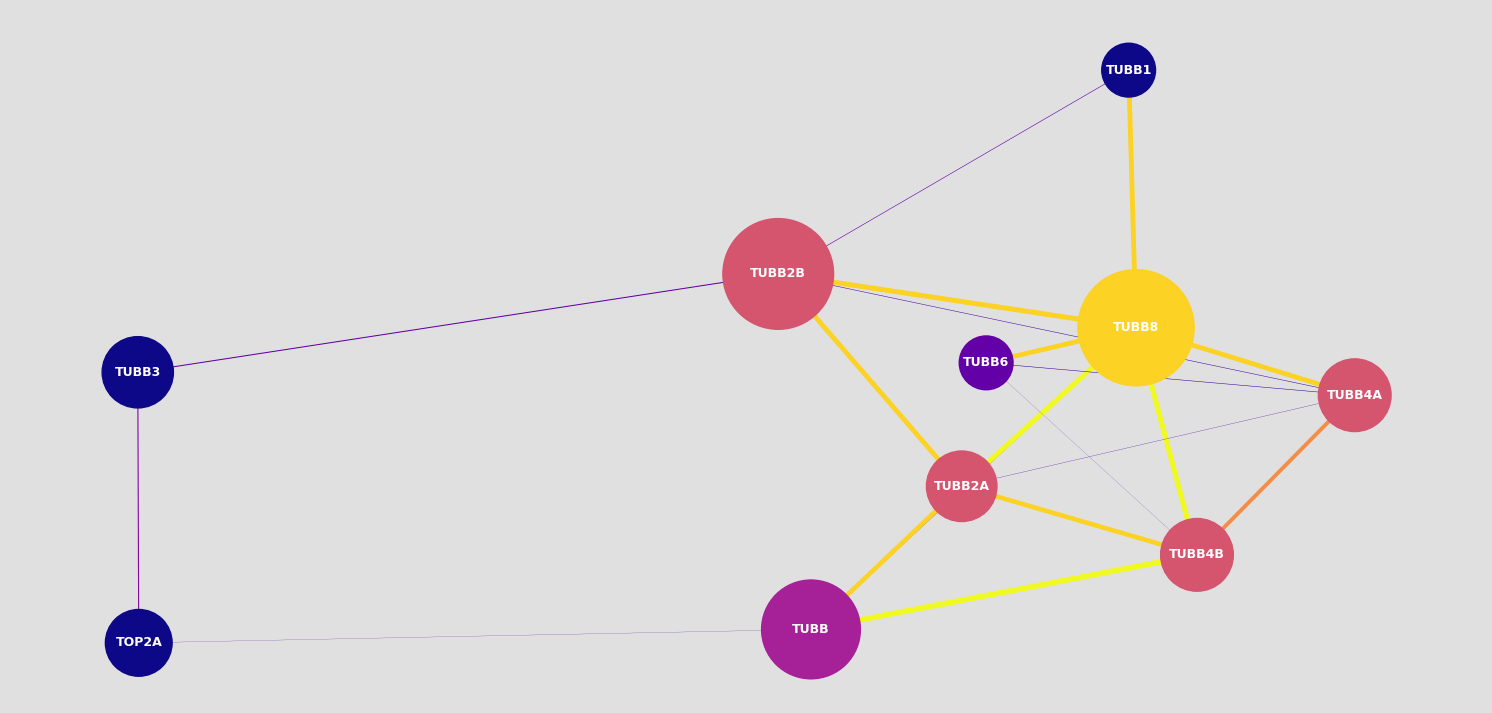

In [12]:
plot_network(hodgkins_graph)

### Karate Club
___

Karate Club is an unsupervised machine learning extension library for NetworkX. It provides network embedding techniques at the node and graph level and includes a variety of overlapping and non-overlapping community detection methods.

There are many different embedding methods and tools in the karateclub package. As I starting point, I'll focus on:
* **DeepWalk:** uses walks that enable the traversal of a graph by moving from one node to another, as long as they are connected to a common edge. If you represent each node in a graph with an arbitrary representation vector, you can traverse the graph. This vectorized format of the graph can then be fed into machine learning models as features.

* **Node2Vec:** The difference between Node2vec and DeepWalk is subtle but significant. Node2vec features a walk bias variable α, which is parameterized by p and q. The parameter p prioritizes a breadth-first-search (BFS) procedure, while the parameter q prioritizes a depth-first-search (DFS) procedure. The decision of where to walk next is therefore influenced by probabilities 1/p or 1/q. BFS is ideal for learning local neighbors, while DFS is better for learning global variables.

Some resources:

https://karateclub.readthedocs.io/en/latest/modules/root.html

https://towardsdatascience.com/overview-of-deep-learning-on-graph-embeddings-4305c10ad4a4


___

The karateclub tools require the nodes to be labeled numerically. The networkX graphs created from PPI data above have the nodes labeled as strings with the protein names.

#### Define function to reindex graph nodes to numeric for further processing such as embedding
#### Also return list of original node names

In [13]:
def reindex_graph(graph):
    import networkx as nx
    node_labels = graph.nodes
    reindexed_graph = nx.relabel.convert_node_labels_to_integers(graph, first_label=0, ordering='default') #first_label is the starting integer label, in this case zero
    return reindexed_graph, node_labels


In [14]:
hodgkins_graph_reindexed, hodgkins_node_labels = reindex_graph(hodgkins_graph)

In [15]:
print(hodgkins_node_labels)
print(hodgkins_graph_reindexed)

['TUBB1', 'TUBB2B', 'TUBB8', 'TUBB4A', 'TUBB3', 'TUBB2A', 'TUBB6', 'TUBB4B', 'TOP2A', 'TUBB']
Graph named 'Protein Interaction Graph' with 10 nodes and 20 edges


### Use KarateClub for graph embedding

#### DeepWalk Embedding

class DeepWalk(walk_number: int = 10, walk_length: int = 80, dimensions: int = 128, workers: int = 4, window_size: int = 5, epochs: int = 1, learning_rate: float = 0.05, min_count: int = 1, seed: int = 42)

Parameters:	
walk_number (int) – Number of random walks. Default is 10.
walk_length (int) – Length of random walks. Default is 80.
dimensions (int) – Dimensionality of embedding. Default is 128.
workers (int) – Number of cores. Default is 4.
window_size (int) – Matrix power order. Default is 5.
epochs (int) – Number of epochs. Default is 1.
learning_rate (float) – HogWild! learning rate. Default is 0.05.
min_count (int) – Minimal count of node occurrences. Default is 1.
seed (int) – Random seed value. Default is 42.

In [16]:
from karateclub import DeepWalk

model = DeepWalk()
model.fit(hodgkins_graph_reindexed)
deepwalk_embedding = model.get_embedding()

print("Shape:", deepwalk_embedding.shape)
print("Sample of Matrix:",deepwalk_embedding[0][0:10])

Shape: (10, 128)
Sample of Matrix: [-0.14228547 -0.00896322 -0.08762524  0.1028519  -0.02074968 -0.03297928
 -0.04668228  0.06185214  0.0347222  -0.10761478]


### Node2Vec Embedding

class Node2Vec(walk_number: int = 10, walk_length: int = 80, p: float = 1.0, q: float = 1.0, dimensions: int = 128, workers: int = 4, window_size: int = 5, epochs: int = 1, learning_rate: float = 0.05, min_count: int = 1, seed: int = 42)

Parameters:	
walk_number (int) – Number of random walks. Default is 10.
walk_length (int) – Length of random walks. Default is 80.
p (float) – Return parameter (1/p transition probability) to move towards from previous node.
q (float) – In-out parameter (1/q transition probability) to move away from previous node.
dimensions (int) – Dimensionality of embedding. Default is 128.
workers (int) – Number of cores. Default is 4.
window_size (int) – Matrix power order. Default is 5.
epochs (int) – Number of epochs. Default is 1.
learning_rate (float) – HogWild! learning rate. Default is 0.05.
min_count (int) – Minimal count of node occurrences. Default is 1.
seed (int) – Random seed value. Default is 42.

In [17]:
from karateclub import Node2Vec

model = Node2Vec(p=1, q=1)
model.fit(hodgkins_graph_reindexed)
Node2Vec_embedding1 = model.get_embedding()

print("Shape:", Node2Vec_embedding1.shape)
print("Sample of Matrix:",Node2Vec_embedding1[0][0:10])

Shape: (10, 128)
Sample of Matrix: [-0.04846295 -0.03372703 -0.06224592  0.05827096 -0.02755684 -0.12448519
 -0.0264236   0.06779189  0.04016348 -0.06927575]


In [18]:
from karateclub import Node2Vec

model = Node2Vec(p=1, q=0.2)
model.fit(hodgkins_graph_reindexed)
BFS_embedding = model.get_embedding()

print("Shape:", BFS_embedding.shape)
print("Sample of Matrix:",BFS_embedding[0][0:10])

Shape: (10, 128)
Sample of Matrix: [ 0.00520798  0.03767336 -0.03813116  0.03180327 -0.07474633 -0.06668352
 -0.01272915  0.03998158  0.08866183 -0.14860283]


In [19]:
from karateclub import Node2Vec

model = Node2Vec(p=0.2, q=1)
model.fit(hodgkins_graph_reindexed)
DFS_embedding = model.get_embedding()

print("Shape:", DFS_embedding.shape)
print("Sample of Matrix:",DFS_embedding[0][0:10])

Shape: (10, 128)
Sample of Matrix: [-0.04846295 -0.03372703 -0.06224592  0.05827096 -0.02755684 -0.12448519
 -0.0264236   0.06779189  0.04016348 -0.06927575]


#### Further work to continue when details of the challenge and dataset are recieved